# **Imports**

In [1]:
from pandas import read_csv
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
from sklearn import preprocessing

In [2]:
DATA_PATH = 'data/'
DATASETS = ['olist_customers_dataset.csv',
           'olist_geolocation_dataset.csv', 
           'olist_order_items_dataset.csv', 
           'olist_order_payments_dataset.csv']

datasets = ["olist_order_reviews_dataset", 
            "olist_orders_dataset", 
            "olist_products_dataset", 
            "olist_sellers_dataset", 
            "product_category_name_translation"]

In [3]:
customers = read_csv(DATA_PATH + DATASETS[0])
geolocation = read_csv(DATA_PATH + DATASETS[1])
items = read_csv(DATA_PATH + DATASETS[2])
payments = read_csv(DATA_PATH + DATASETS[3])

On constate que les bases de données des commandes et des objets en magasin sont centrales

# **Pré-process**

## Customers

La table des clients regroupe:

* L'id des clients
* L'id unique des clients 
* Le code postal du client
* La ville du client
* L'Etat du client

La variable qui nous intéressent ici est l'Etat du client

In [4]:
customers.duplicated().sum()
# No duplication of data

0

In [5]:
customers.isna().sum()
# No missing data

customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

In [6]:
customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [7]:
customers.customer_city.unique()

array(['franca', 'sao bernardo do campo', 'sao paulo', ...,
       'monte bonito', 'sao rafael', 'eugenio de castro'], dtype=object)

La ville comporte beaucoup trop de valeurs uniques pour être convertie en variables catégorielles. La variable "state" est plus adaptée, elle comporte tout de meme 27 valeurs uniques mais il est nécessaire que l'on ait au moins une donnée sur la localisation des clients. 

In [8]:
customers['state_cat'] = customers['customer_state'].astype('category')

In [9]:
state = customers.groupby(by='customer_state').count().customer_id.sort_values(ascending=False)
state
# Many customers in Sao Paolo

customer_state
SP    41746
RJ    12852
MG    11635
RS     5466
PR     5045
SC     3637
BA     3380
DF     2140
ES     2033
GO     2020
PE     1652
CE     1336
PA      975
MT      907
MA      747
MS      715
PB      536
PI      495
RN      485
AL      413
SE      350
TO      280
RO      253
AM      148
AC       81
AP       68
RR       46
Name: customer_id, dtype: int64

In [10]:
(state.SP/state.sum())*100

41.980671956235355

41% des clients sont regroupés dans l'Etat de Sao-Paolo

## Geoloc

Cette table regroupe la géolocalisation des codes postaux des clients

Cette table sera surtout utile pour analyser les client post-clustering

In [11]:
geolocation.duplicated().sum()

261831

26.17% of data is duplicated

In [12]:
geolocation.drop_duplicates(inplace=True)

In [13]:
geolocation.isna().sum()

geolocation_zip_code_prefix    0
geolocation_lat                0
geolocation_lng                0
geolocation_city               0
geolocation_state              0
dtype: int64

In [14]:
geolocation.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP


In [15]:
geolocation.geolocation_zip_code_prefix.unique().shape

(19015,)

In [16]:
geolocation.shape

(738332, 5)

## Items

Cette table regroupe les informations des commandes 

* l'id de la commande
* **order_item_id** : Nombre d'articles du panier.
* l'id produit (article)
* id du vendeur
* date limite d'envoi pour le venduer
* price 
* frais de port

Les variables qui nous intéressent ici sont 
* price
* frais de port
* order_item_id

In [17]:
items.columns
# Freight value ?
# Prix du freight = cout du transport

Index(['order_id', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value'],
      dtype='object')

In [18]:
items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [19]:
# On convertit la colonne des dates d'une chaine de caractère au format datetime

items.loc[:, 'shipping_limit_date'] = items.shipping_limit_date.apply(pd.to_datetime)

In [20]:
items.isna().mean()

order_id               0.0
order_item_id          0.0
product_id             0.0
seller_id              0.0
shipping_limit_date    0.0
price                  0.0
freight_value          0.0
dtype: float64

In [21]:
items.duplicated().sum()

0

In [22]:
items[['price', 'freight_value']].corr()
# IL y a une corrélation entre le prix et les frais de port

,price,freight_value
price,1.000000,0.414204
freight_value,0.414204,1.000000


In [23]:
items[['price', 'freight_value']].describe()

,price,freight_value
count,112650.000000,112650.000000
mean,120.653739,19.990320
std,183.633928,15.806405
min,0.850000,0.000000
25%,39.900000,13.080000
50%,74.990000,16.260000
75%,134.900000,21.150000
max,6735.000000,409.680000


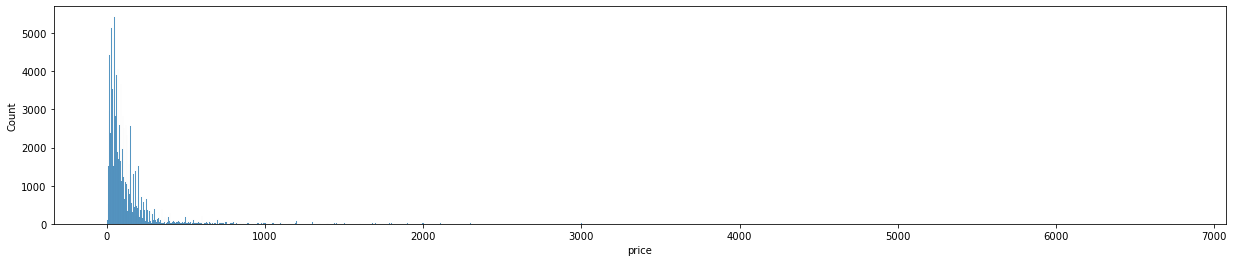

In [24]:
sns.histplot(items.price)
fig = plt.gcf()
fig.set_size_inches(21, 4)

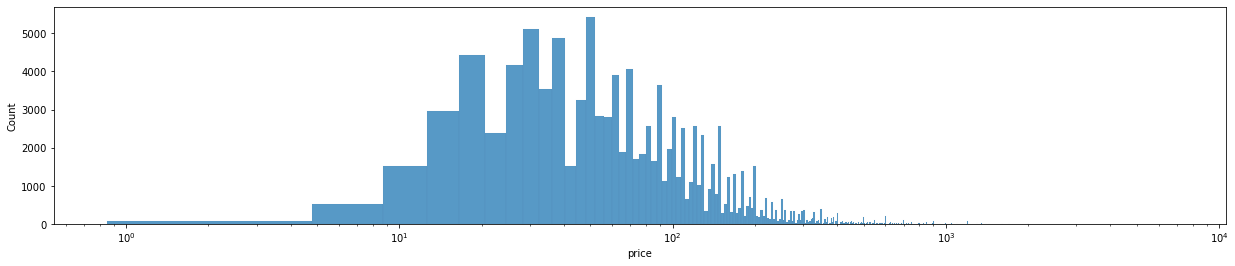

In [25]:
sns.histplot(items.price).set_xscale('log')
fig = plt.gcf()
fig.set_size_inches(21, 4)

In [26]:
import math

items['log_price'] = items['price'].transform(math.log)

On voit que l'on peut passer ces données en log pour que le clustering soit plus efficace. 

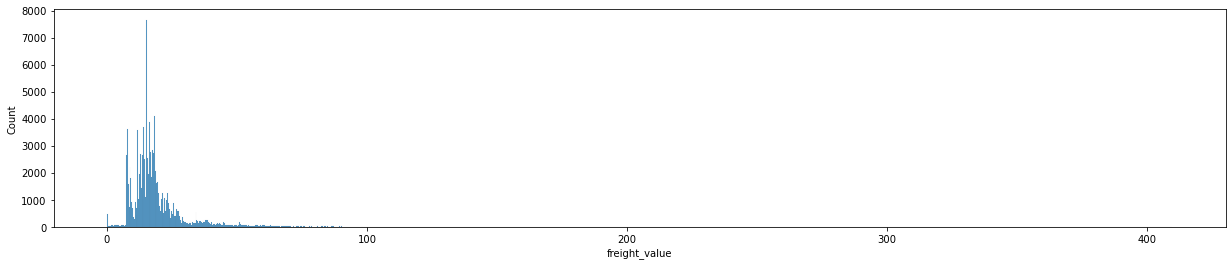

In [27]:
sns.histplot(items.freight_value)
fig = plt.gcf()
fig.set_size_inches(21, 4)

In [28]:
def log_transf_0(x):
    if x != 0:
        return math.log(x)
    else:
        return x

items['log_freight_value'] = items['freight_value'].transform(log_transf_0)
# Nous souhaitons garder les observations dans lesquelles les frais de port sont nuls
# Cela peut-être une incitation pour le client

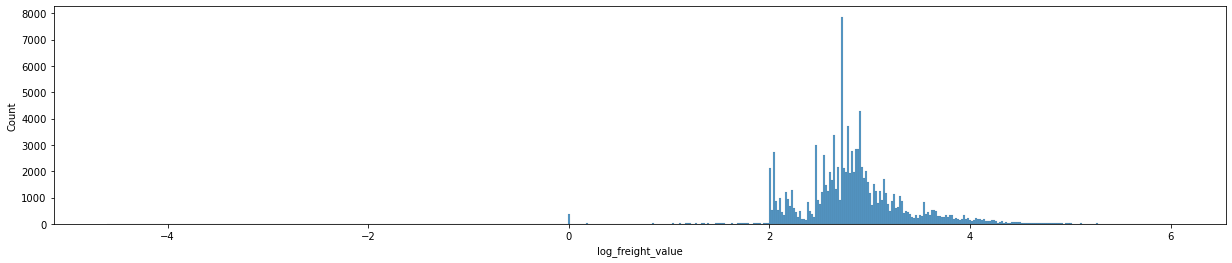

In [29]:
sns.histplot(items.log_freight_value)
fig = plt.gcf()
fig.set_size_inches(21, 4)

## Payments

Cette table comporte les commandes des clients

* L'ID de la commande
* **payment_sequential** : Un client peut choisir de payer avec plus d'un moyen de paiement. Dans ce cas, une séquence sera créée pour accomoder ces paiements.
* **payment_type**: Méthode de paiement.
* **payment_installments**: Nombre de paiements.
* Montant du paiement

Il n'y a pas de données sur le client lui-même cela dit, cette information doit être allée chercher dans la table des commandes

Les variables qui nous interessent sont:
* payment_sequential
* payment_type_cat (categorielle)
* payment_installments
* payment_value

In [30]:
payments.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


In [31]:
payments.isna().sum()

order_id                0
payment_sequential      0
payment_type            0
payment_installments    0
payment_value           0
dtype: int64

In [32]:
payments.payment_value.describe()

count    103886.000000
mean        154.100380
std         217.494064
min           0.000000
25%          56.790000
50%         100.000000
75%         171.837500
max       13664.080000
Name: payment_value, dtype: float64

Pourquoi un paiement de 13664 si max du prix 6735 ?

Il y a des paiements nuls

---> Un gros panier **à vérifier le nombre d'article dans le panier**

In [33]:
temp = payments[payments['payment_installments'] == 0].shape[0]
print(f'Il y a {temp} paiements faits en 0 fois')

temp = payments[payments['payment_value'] == 0].shape[0]
print(f'Il y a {temp} paiemients faits en 0 fois')

Il y a 2 paiements faits en 0 fois
Il y a 9 paiemients faits en 0 fois


On supprime les clients qui ont payé 0 fois ou rien payé, car par nature ça ne nous intéresse pas

In [34]:
payments = payments[payments['payment_installments'] != 0]
payments = payments[payments['payment_value'] != 0]

In [35]:
payments['payment_type_cat'] = payments.payment_type.astype('category')

In [36]:
payments.groupby(by='payment_type_cat').count().order_id

payment_type_cat
boleto         19784
credit_card    76793
debit_card      1529
voucher         5769
Name: order_id, dtype: int64

In [37]:
payments.groupby(by='payment_sequential').count().order_id.head()

payment_sequential
1    99357
2     3037
3      580
4      275
5      170
Name: order_id, dtype: int64

In [38]:
payments.groupby(by='payment_installments').count().order_id.head()

payment_installments
1    52537
2    12413
3    10461
4     7098
5     5239
Name: order_id, dtype: int64

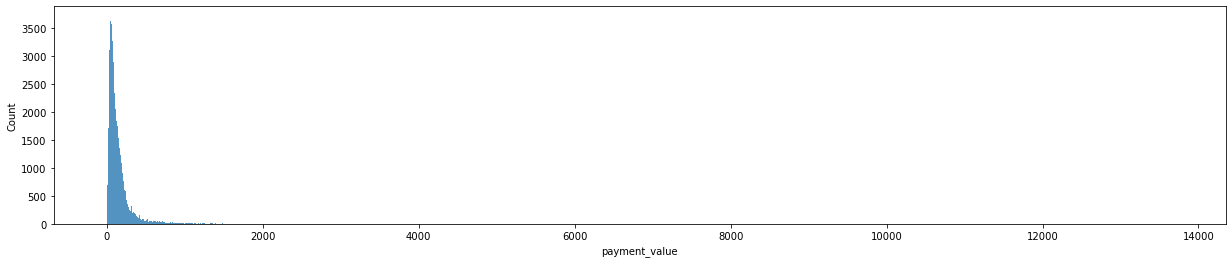

In [39]:
sns.histplot(payments.payment_value)
fig = plt.gcf()
fig.set_size_inches(21, 4)

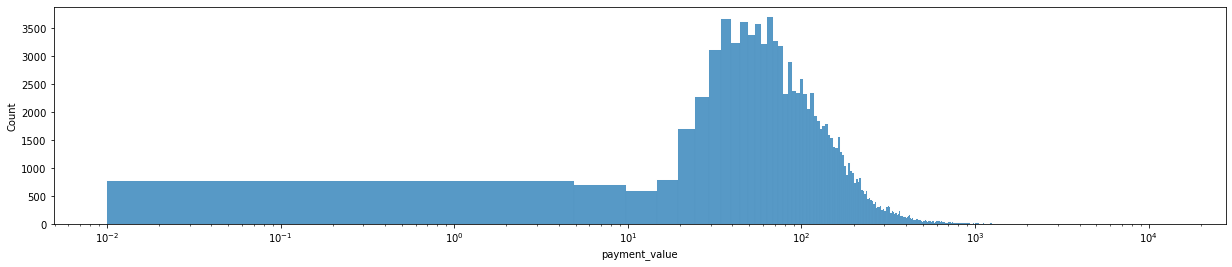

In [40]:
sns.histplot(payments.payment_value).set_xscale('log')
fig = plt.gcf()
fig.set_size_inches(21, 4)

La transformation en log n'est pas satisfaisante car elle concentre encore beaucoup de valeurs autour de 0.01-1

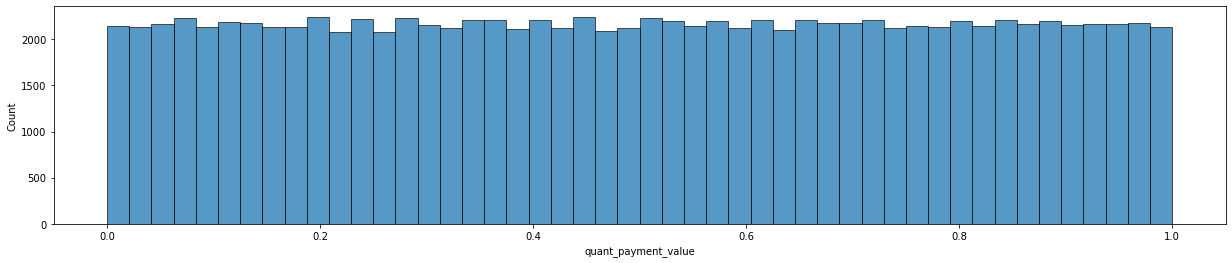

In [41]:
from sklearn.preprocessing import quantile_transform

X = payments['payment_value'].sort_values(ascending=True).values.reshape(-1, 1)
payments['quant_payment_value'] = quantile_transform(X, axis=0, n_quantiles=200)

sns.histplot(payments.quant_payment_value)
fig = plt.gcf()
fig.set_size_inches(21, 4)

Cette distribution permettra aux algorithmes de clustering de mieux différencier les données entre elles

In [42]:
import pandas as pd
from scipy import stats
import numpy as np
import seaborn as sns
from sklearn import preprocessing
pd.options.mode.chained_assignment = None  # default='warn'

In [43]:
dfs = []
for dts in datasets:
    dfs.append(pd.read_csv(f"data/{dts}.csv"))

## Aperçu des jeux de données

In [44]:
dfs[0].head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [45]:
dfs[1].head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [46]:
dfs[2].head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


In [47]:
dfs[3].head()

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP


In [48]:
dfs[4].head()

,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor


## Selection des features pertinentes pour la segmentation

In [49]:
del dfs[2]["product_name_lenght"]
del dfs[2]["product_description_lenght"]
del dfs[2]["product_photos_qty"]
del dfs[0]["review_comment_title"]
del dfs[0]["review_comment_message"]

## Preprocess sur les valeurs manquantes

### order reviews

In [50]:
(dfs[0].isna().sum()/dfs[0].shape[0]).sort_values(ascending=True).reset_index(name="percentage_na")

,index,percentage_na
0,review_id,0.0
1,order_id,0.0
2,review_score,0.0
3,review_creation_date,0.0
4,review_answer_timestamp,0.0


In [51]:
cat_cols = ["review_answer_timestamp"]
dfs[0][cat_cols] = dfs[0][cat_cols].fillna("unknow")

___

### orders dataset

In [52]:
na_data = (dfs[1].isna().sum()/dfs[1].shape[0]).sort_values(ascending=True).reset_index(name="percentage_na")
na_data

,index,percentage_na
0,order_id,0.000000
1,customer_id,0.000000
2,order_status,0.000000
3,order_purchase_timestamp,0.000000
4,order_estimated_delivery_date,0.000000
5,order_approved_at,0.001609
6,order_delivered_carrier_date,0.017930
7,order_delivered_customer_date,0.029817


In [53]:
dfs[1] = dfs[1].dropna()

___

### products dataset

In [54]:
(dfs[2].isna().sum()/dfs[2].shape[0]).sort_values(ascending=True).reset_index(name="percentage_na")

,index,percentage_na
0,product_id,0.000000
1,product_weight_g,0.000061
2,product_length_cm,0.000061
3,product_height_cm,0.000061
4,product_width_cm,0.000061
5,product_category_name,0.018512


In [55]:
cat_cols = "product_category_name"
dfs[2][cat_cols] = dfs[2][cat_cols].fillna("unknow")

num_cols = list(dfs[2].select_dtypes(include="float64").columns)
dfs[2].update(dfs[2][num_cols].fillna(dfs[2].median()))

___

### sellers dataset

In [56]:
(dfs[3].isna().sum()/dfs[3].shape[0]).sort_values(ascending=True).reset_index(name="percentage_na")

,index,percentage_na
0,seller_id,0.0
1,seller_zip_code_prefix,0.0
2,seller_city,0.0
3,seller_state,0.0


___

### category name translation

In [57]:
(dfs[4].isna().sum()/dfs[4].shape[0]).sort_values(ascending=True).reset_index(name="percentage_na")

,index,percentage_na
0,product_category_name,0.0
1,product_category_name_english,0.0


## Preprocess sur les Outliers
### Aucun outliers présent dans les 5 dataframes, les données présentes ne sont pas vraiment susceptible à etre des outliers

In [58]:
df2_num = dfs[2].select_dtypes(include="float64")
df2_num[(np.abs(stats.zscore(df2_num)) > 3).all(axis=1)]

,product_weight_g,product_length_cm,product_height_cm,product_width_cm


C:\Users\matt\anaconda3\envs\ML\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='0'>

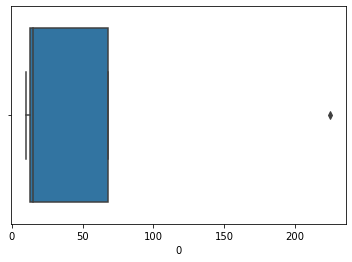

In [59]:
sns.boxplot(df2_num.iloc[0])

### Regroupement des données par caractéristiques principales


In [60]:
dfs[1]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00
...,...,...,...,...,...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28 00:00:00
99437,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02 00:00:00
99438,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27 00:00:00
99439,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15 00:00:00


In [61]:
dates = ['review_creation_date', 'review_answer_timestamp']
dates2= ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']
dfs[0][dates] = dfs[0][dates].apply(pd.to_datetime, errors="coerce")
dfs[1][dates2] = dfs[1][dates2].apply(pd.to_datetime, errors="coerce")

In [62]:
dfs[1].groupby(pd.Grouper(key="order_purchase_timestamp", freq="M")).count()["order_id"].sort_values(ascending=False)

order_purchase_timestamp
2017-11-30    7288
2018-01-31    7069
2018-03-31    7003
2018-04-30    6798
2018-05-31    6749
2018-02-28    6556
2018-08-31    6351
2018-07-31    6156
2018-06-30    6096
2017-12-31    5513
2017-10-31    4478
2017-08-31    4193
2017-09-30    4149
2017-07-31    3872
2017-05-31    3545
2017-06-30    3135
2017-03-31    2546
2017-04-30    2303
2017-02-28    1641
2017-01-31     748
2016-10-31     270
2016-12-31       1
2016-09-30       1
2016-11-30       0
Name: order_id, dtype: int64

In [63]:
dfs[3].groupby("seller_city").count()["seller_id"].sort_values(ascending=False)

seller_city
sao paulo         694
curitiba          127
rio de janeiro     96
belo horizonte     68
ribeirao preto     52
                 ... 
muriae              1
neopolis            1
nhandeara           1
nova lima           1
04482255            1
Name: seller_id, Length: 611, dtype: int64

In [64]:
dfs[3].groupby("seller_state").count()["seller_id"].sort_values(ascending=False)

seller_state
SP    1849
PR     349
MG     244
SC     190
RJ     171
RS     129
GO      40
DF      30
ES      23
BA      19
CE      13
PE       9
PB       6
MS       5
RN       5
MT       4
SE       2
RO       2
AM       1
PA       1
MA       1
PI       1
AC       1
Name: seller_id, dtype: int64

In [65]:
dfs[0].groupby("review_score").count()["order_id"].sort_values()

review_score
2     3151
3     8179
1    11424
4    19142
5    57328
Name: order_id, dtype: int64

In [66]:
dfs[1].groupby("order_status").count()["order_id"].sort_values()

order_status
canceled         6
delivered    96455
Name: order_id, dtype: int64

In [67]:
dfs[2].groupby("product_category_name").count()["product_id"].sort_values(ascending=False)

product_category_name
cama_mesa_banho                  3029
esporte_lazer                    2867
moveis_decoracao                 2657
beleza_saude                     2444
utilidades_domesticas            2335
                                 ... 
casa_conforto_2                     5
fashion_roupa_infanto_juvenil       5
pc_gamer                            3
seguros_e_servicos                  2
cds_dvds_musicais                   1
Name: product_id, Length: 74, dtype: int64

## Standardisation

In [68]:
reviews = dfs[0].copy()
transf_col = list(reviews.select_dtypes(["int64", "datetime64[ns]"]).columns)
date_cols = transf_col[1:]
nums_cols = transf_col[0]
min_max_scaler = preprocessing.MinMaxScaler()
reviews[nums_cols] = min_max_scaler.fit_transform(reviews[nums_cols].to_numpy().reshape(-1, 1))
#reviews[date_cols] = min_max_scaler.fit_transform(reviews[date_cols])

In [69]:
orders = dfs[1].copy()
cat_cols = ["order_status"]
date_cols = list(dfs[1].select_dtypes("datetime64[ns]").columns)
orders[cat_cols] = orders[cat_cols].astype('category')
#orders[date_cols] = min_max_scaler.fit_transform(orders[date_cols])

In [70]:
products = dfs[2].copy()
cat_cols = ["product_category_name"]
num_cols = list(dfs[2].select_dtypes("float64").columns)

products[cat_cols] = products[cat_cols].astype('category')
products[num_cols] = min_max_scaler.fit_transform(products[num_cols])

In [71]:
sellers = dfs[3].copy()
cat_cols = ["seller_city", "seller_state"]
sellers[cat_cols] = sellers[cat_cols].astype('category')

In [72]:
products_translation = dfs[4].copy()
products_translation = products_translation.astype("category")

In [73]:
orders.groupby("customer_id").count()

,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
customer_id,,,,,,,
00012a2ce6f8dcda20d059ce98491703,1,1,1,1,1,1,1
000161a058600d5901f007fab4c27140,1,1,1,1,1,1,1
0001fd6190edaaf884bcaf3d49edf079,1,1,1,1,1,1,1
0002414f95344307404f0ace7a26f1d5,1,1,1,1,1,1,1
000379cdec625522490c315e70c7a9fb,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...
fffcb937e9dd47a13f05ecb8290f4d3e,1,1,1,1,1,1,1
fffecc9f79fd8c764f843e9951b11341,1,1,1,1,1,1,1
fffeda5b6d849fbd39689bb92087f431,1,1,1,1,1,1,1


# Merge

Nous avons suivi le schéma suivant pour fusionner les tables

![image info](BDD.png)

In [74]:
order_final = pd.merge(orders, payments, how='inner', on='order_id')
order_final = pd.merge(order_final, reviews, how='inner', on='order_id')
order_final = pd.merge(order_final, customers, how='inner', on='customer_id')

In [75]:
order_final.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'payment_sequential', 'payment_type', 'payment_installments',
       'payment_value', 'payment_type_cat', 'quant_payment_value', 'review_id',
       'review_score', 'review_creation_date', 'review_answer_timestamp',
       'customer_unique_id', 'customer_zip_code_prefix', 'customer_city',
       'customer_state', 'state_cat'],
      dtype='object')

In [76]:
items_final = pd.merge(items, products, how='inner', on='product_id')
items_final = pd.merge(items_final, sellers, how='inner', on='seller_id')

In [77]:
df_final = pd.merge(order_final, items_final, how='inner', on='order_id')
df_final = pd.merge(df_final, products_translation, how='inner', on='product_category_name')

In [78]:
df_final.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'payment_sequential', 'payment_type', 'payment_installments',
       'payment_value', 'payment_type_cat', 'quant_payment_value', 'review_id',
       'review_score', 'review_creation_date', 'review_answer_timestamp',
       'customer_unique_id', 'customer_zip_code_prefix', 'customer_city',
       'customer_state', 'state_cat', 'order_item_id', 'product_id',
       'seller_id', 'shipping_limit_date', 'price', 'freight_value',
       'log_price', 'log_freight_value', 'product_category_name',
       'product_weight_g', 'product_length_cm', 'product_height_cm',
       'product_width_cm', 'seller_zip_code_prefix', 'seller_city',
       'seller_state', 'product_category_name_english'],
      dtype='object')

In [79]:
df_final = df_final.drop('product_category_name', axis=1)

In [80]:
df_final.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,...,log_price,log_freight_value,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state,product_category_name_english
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1,credit_card,...,3.400864,2.165619,0.012369,0.122449,0.058252,0.062500,9350,maua,SP,housewares
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,3,voucher,...,3.400864,2.165619,0.012369,0.122449,0.058252,0.062500,9350,maua,SP,housewares
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,2,voucher,...,3.400864,2.165619,0.012369,0.122449,0.058252,0.062500,9350,maua,SP,housewares
3,6ea2f835b4556291ffdc53fa0b3b95e8,c7340080e394356141681bd4c9b8fe31,delivered,2017-11-24 21:27:48,2017-11-25 00:21:09,2017-12-13 21:14:05,2017-12-28 18:59:23,2017-12-21,1,credit_card,...,5.826000,2.840247,0.353741,0.316327,0.310680,0.250000,89165,rio do sul,SC,housewares
4,82bce245b1c9148f8d19a55b9ff70644,388025bec8128ff20ec1a316ed4dcf02,delivered,2017-04-20 17:15:46,2017-04-21 05:15:56,2017-04-24 09:34:13,2017-05-10 09:17:55,2017-05-12,1,boleto,...,3.637586,2.744704,0.017440,0.275510,0.194175,0.196429,4445,sao paulo,SP,housewares


# Etude des données

## Fréquence et quantité d'achat

In [81]:
def comp_delta_date(x):
    '''Fonction destinée à calculer la différence moyenne entre chaque date'''
    if x.shape[0] == 1:
        return 0
    i = 0
    for date in x:
        if i == 0:
            temp = date
        else:
            None
             

In [82]:
# Combien de fois chaque client a acheté sur ce site

customer_nb_achat = df_final.groupby('customer_id').count().order_id
customer_total_paiments = df_final[['customer_id', 'payment_value']].groupby('customer_id').sum().payment_value
customer_mean_freq = df_final[['customer_id', 'order_purchase_timestamp']].groupby('customer_id').diff()

In [83]:
customer_nb_achat.sort_values(ascending=False).head(10)

customer_id
270c23a11d024a44c896d1894b261a83    63
13aa59158da63ba0e93ec6ac2c07aacb    38
92cd3ec6e2d643d4ebd0e3d6238f69e2    26
d22f25a9fadfb1abbc2e29395b1239f4    24
63b964e79dee32a3587651701a2b8dbf    24
86cc80fef09f7f39df4b0dbce48e81cb    24
6ee2f17e3b6c33d6a9557f280edd2925    24
2ba91e12e5e4c9f56b82b86d9031d329    24
b246eeed30b362c09d867b9e598bee51    22
be1c4e52bb71e0c54b11a26b8e8d59f2    22
Name: order_id, dtype: int64

In [84]:
customer_total_paiments.sort_values(ascending=False)

customer_id
1617b1357756262bfa56ab541c47bc16    109312.64
be1b70680b9f9694d8c70f41fa3dc92b     44048.00
05455dfa7cd02f13d132aa7a6a9729c6     36489.24
1ff773612ab8934db89fd5afa8afe506     30186.00
ec5b2ba62e574342386871631fafd3fc     29099.52
                                      ...    
d2c63ad286e3ca9dd69218008d61ff81        11.62
046f890135acc703faff4c1fc0c2d73c        11.56
8e4bd65db637116b6b68109e4df21b84        10.89
184e8e8e48937145eb96c721ef1f0747        10.07
a790343ca6f3fee08112d678b43aa7c5         9.59
Name: payment_value, Length: 94470, dtype: float64

In [85]:
customer_mean_freq

,order_purchase_timestamp
0,NaT
1,0 days
2,0 days
3,NaT
4,NaT
...,...
113182,NaT
113183,0 days
113184,NaT
113185,NaT


In [98]:
## En combien de fois le client paye en moyenne
df1 = df_final.groupby(["customer_unique_id"])["payment_sequential"].median()

In [99]:
## Note moyenne de statisfaction du client
df2 = df_final.groupby(["customer_unique_id"])["review_score"].median()

In [101]:
## Type de paiment utilisé en moyenne
## transformation par l'encodage du type de paiement -> récupération de la valeur médianne -> transfo d'encodage inverse

df_payment_type = df_final[["customer_unique_id", "payment_type"]]
encoder = preprocessing.LabelEncoder()
encoder.fit(df_payment_type["payment_type"])

df_payment_type["payment_type"] = encoder.transform(df_payment_type["payment_type"])

df3 = df_payment_type.groupby(["customer_unique_id"])["payment_type"].median().astype(int).reset_index()
df3["payment_type"] = encoder.inverse_transform(df3["payment_type"])

df3

,customer_unique_id,payment_type
0,0000366f3b9a7992bf8c76cfdf3221e2,credit_card
1,0000b849f77a49e4a4ce2b2a4ca5be3f,credit_card
2,0000f46a3911fa3c0805444483337064,credit_card
3,0000f6ccb0745a6a4b88665a16c9f078,credit_card
4,0004aac84e0df4da2b147fca70cf8255,credit_card
...,...,...
91459,fffcf5a5ff07b0908bd4e2dbc735a684,credit_card
91460,fffea47cd6d3cc0a88bd621562a9d061,credit_card
91461,ffff371b4d645b6ecea244b27531430a,credit_card
91462,ffff5962728ec6157033ef9805bacc48,credit_card


In [102]:
## Type de produit acheté en general

df_product_cat = df_final[["customer_unique_id", "product_category_name_english"]]
encoder = preprocessing.LabelEncoder()
encoder.fit(df_product_cat["product_category_name_english"])

df_product_cat["product_category_name_english"] = encoder.transform(df_product_cat["product_category_name_english"])

df4 = df_product_cat.groupby(["customer_unique_id"])["product_category_name_english"].median().astype(int).reset_index()
df4["product_category_name_english"] = encoder.inverse_transform(df4["product_category_name_english"])

df4

,customer_unique_id,product_category_name_english
0,0000366f3b9a7992bf8c76cfdf3221e2,bed_bath_table
1,0000b849f77a49e4a4ce2b2a4ca5be3f,health_beauty
2,0000f46a3911fa3c0805444483337064,stationery
3,0000f6ccb0745a6a4b88665a16c9f078,telephony
4,0004aac84e0df4da2b147fca70cf8255,telephony
...,...,...
91459,fffcf5a5ff07b0908bd4e2dbc735a684,health_beauty
91460,fffea47cd6d3cc0a88bd621562a9d061,baby
91461,ffff371b4d645b6ecea244b27531430a,auto
91462,ffff5962728ec6157033ef9805bacc48,watches_gifts


In [105]:
from functools import reduce
df_result = reduce(lambda x,y: pd.merge(x,y, on='customer_unique_id', how='inner'), [df1, df2, df3, df4])
df_result

,customer_unique_id,payment_sequential,review_score,payment_type,product_category_name_english
0,0000366f3b9a7992bf8c76cfdf3221e2,1.0,1.00,credit_card,bed_bath_table
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1.0,0.75,credit_card,health_beauty
2,0000f46a3911fa3c0805444483337064,1.0,0.50,credit_card,stationery
3,0000f6ccb0745a6a4b88665a16c9f078,1.0,0.75,credit_card,telephony
4,0004aac84e0df4da2b147fca70cf8255,1.0,1.00,credit_card,telephony
...,...,...,...,...,...
91459,fffcf5a5ff07b0908bd4e2dbc735a684,1.0,1.00,credit_card,health_beauty
91460,fffea47cd6d3cc0a88bd621562a9d061,1.0,0.75,credit_card,baby
91461,ffff371b4d645b6ecea244b27531430a,1.0,1.00,credit_card,auto
91462,ffff5962728ec6157033ef9805bacc48,1.0,1.00,credit_card,watches_gifts
